### Code to compute the likelihood of a genealogy under a specific selection coefficient
#### (building on principles from moments, Stephens & Donnelly 2003 and importance sampling _a la_ CLUES, with the key equations coming from the transition probabilities in each generation)

Here, $T$ is the age of the allele in generations, $s$ is the selection coefficient and $n_0$ is the sample size in the present day. 

\begin{align*}
P\left(\mathcal{G} \mid n_0, s, T \right) &= P\left(i_T, i_{T-1}, \ldots, i_1, i_0, n_T, n_{T-1}, \ldots, n_1 \mid n_0, s, T \right) \\
&= P\left(n_T \mid n_{T-1}, \ldots \right) \times P\left(i_T \mid n_T, \ldots \right) \times P\left(i_{T-1} \mid i_T,\ldots \right) \times \ldots \times P\left(i_0 \mid n_0, s, T\right) \times P\left(T\mid n_0, s\right) \\
&= P\left(n_T \mid n_{T-1}, \ldots \right) \times P\left(i_T \mid n_T, \ldots \right) \times P\left(i_T \mid i_{T-1}, \ldots\right) \frac{P\left(i_{T-1}\mid n_{T-1}, \ldots\right)}{P\left(i_T \mid n_T,\ldots\right)} \times \ldots \times P\left(i_0 \mid n_0, s, T\right) \times P\left(T\mid n_0, s\right) \\
&= P\left(n_T \mid n_{T-1}, \ldots \right) \times P\left(i_T \mid i_{T-1}, \ldots\right) \times \ldots \times P\left(i_0 \mid n_0, s, T\right)^2 \times P\left(T\mid n_0, s\right) 
\end{align*}

In [1]:
%load_ext autoreload
%autoreload 2

# numerics + rv stuff
import numpy as np
import scipy as sp
from numpy.random import default_rng
import moments
from joblib import Parallel, delayed

# plotting + misc tools
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
import itertools as it
import matplotlib.colors as colors
# import matplotlib.cm as cm
import pandas as pd
import os
# method of moments framework + helper functions
from mom_functions import *
import newick
from newick import load
import readline
import tskit

# rng setup
rng = default_rng(100496)

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["figure.figsize"] = [5, 3.5]
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.axisbelow"] = True
plt.rcParams.update({"figure.facecolor": "white"})

# set numpy print option to a more readable format for floats
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [ ]:
## defunct now (not using the generation by generation formulation)
def calc_loglik_gen_xx(s, T, gendata, N):
    """
    Function to compute the likelihood of a genealogy under a specific selection coefficient and age of derived allele. 
    s : float, additive selection coefficient with h = 1/2
    T : int, age of derived allele in generations
    gendata : list of tuples, with # of elements indicating the height of the genealogy (in generations) & each tuple containing the # of derived lineages and total # of lineages in a specific generation (i, n), where i <= n (first element contains values from the present day)
    N : int, assuming constant population size (# of diploid inds)
    """

    pn, pi = 0, 0
    probarray = np.zeros(len(gendata))

    # going from the top to the bottom 
    for gen in range(1,len(gendata))[::-1]:
        # na = nb + 1
        if gendata[gen-1][1] > gendata[gen][1]:
            pn = 0.25*gendata[gen-1][1]*(gendata[gen-1][1]-1)/N
            # ia = ib + 1
            if gendata[gen-1][0] > gendata[gen][0]:
                pi = gendata[gen][0]/gendata[gen][1]
            # ia = ib
            else:
                pi = 1 - gendata[gen][0]/gendata[gen][1]
        # na = nb
        else: 
            pn = 1 - 0.25*gendata[gen-1][1]*(gendata[gen-1][1]-1)/N
            # ia = ib + 1
            if gendata[gen-1][0] > gendata[gen][0]:
                pi = s*gendata[gen][0]/gendata[gen][1]
            # ia = ib
            else:
                pi = 1 - s*gendata[gen][0]/gendata[gen][1]
        probarray[gen] = pn*pi
    
    fs = moments.Spectrum(np.array([0]+[1]+[0]*(gendata[0][1]-1)))
    # VS: check this scaled rate 
    fs.integrate([1], 0.5*T/N, gamma=2*N*s, theta=100)

    # VS: check the indexing on the returned SFAS object (reverse or correct)
    fsa = run_mom_iterate_constant(100, gendata[0][1], s, N, 100, {})

    probarray[0] = (fs[gendata[0][0]]/fs.sum())**2 * fsa[T,gendata[0][0]]/fsa[:,gendata[0][0]].sum()

    return sp.special.logsumexp(probarray) #-> returns the log-likelihood

In [ ]:
# simulating a random genealogy under a specific selection coefficient
# gendata = [(2,5)] + [(1,4)] + [(1,4)] + [(1,3)] + [(1,2)] 

In [ ]:
# _projection_cache = {}
# def _cached_projection(proj_to, proj_from, hits, _projection_cache):
#     key = (proj_to, proj_from, hits)
#     # checking if this value has already been computed
#     try:
#         return _projection_cache[key]
#     except KeyError:
#         pass

#     proj_hits = np.arange(proj_to + 1) #proj_from - proj_to, hits - proj_hits
#     lncontrib =  sp.special.gammaln(proj_to + 1) - sp.special.gammaln(proj_hits + 1) - sp.special.gammaln(proj_to - proj_hits + 1) + sp.special.gammaln(proj_from - proj_to + 1) - sp.special.gammaln(hits - proj_hits) - sp.special.gammaln(proj_from - proj_to - hits + proj_hits + 1) - sp.special.gammaln(proj_from + 1) - sp.special.gammaln(hits + 1) + sp.special.gammaln(proj_from - hits + 1)

#     contrib = np.exp(lncontrib)

#     _projection_cache[key] = contrib
#     return contrib

# def _project_one_axis(fs, proj_to):
#     newfs = np.zeros(proj_to + 1)
#     proj_from = fs.sample_sizes[0]
#     for hits in range(1, proj_from):
#         least, most = max(proj_to - (proj_from - hits), 0), min(hits, proj_to)
#         proj = _cached_projection(proj_to, proj_from, hits, _projection_cache)
#         newfs[least:(most + 1)] +=  (fs[hits:(hits + 1)] * proj[least:(most + 1)])

#     return newfs

# %time _project_one_axis(fs, 302) ## --> wrong, but also slower
# %time fs.project([4])

#### How to extract true trees from mssel and convert to format readable by my code?

- Use the `-T` flag to output trees in Newick format in mssel
    - which tree to read in though? (units are in $4N_0$ gens)
- How to say which lineages are derived vs ancestral? 

In [2]:
## code from tsconvert (https://github.com/tskit-dev/tsconvert/blob/main/tsconvert/newick.py) to get tree-sequence from newick
def from_newick(
    string, *, min_edge_length=0, span=1, time_units=None, node_name_key=None
) -> tskit.TreeSequence:
    """
    Create a tree sequence representation of the specified newick string.

    The tree sequence will contain a single tree, as specified by the newick. All
    leaf nodes will be marked as samples (``tskit.NODE_IS_SAMPLE``). Newick names and
    comments will be written to the node metadata. This can be accessed using e.g.
    ``ts.node(0).metadata["name"]``.

    :param string string: Newick string
    :param float min_edge_length: Replace any edge length shorter than this value by this
        value. Unlike newick, tskit doesn't support zero or negative edge lengths, so
        setting this argument to a small value is necessary when importing trees with
        zero or negative lengths.
    :param float span: The span of the tree, and therefore the
        :attr:`~TreeSequence.sequence_length` of the returned tree sequence.
    :param str time_units: The value assigned to the :attr:`~TreeSequence.time_units`
        property of the resulting tree sequence. Default: ``None`` resulting in the
        time units taking the default of :attr:`tskit.TIME_UNITS_UNKNOWN`.
    :param str node_name_key: The metadata key used for the node names. If ``None``
        use the string ``"name"``, as in the example of accessing node metadata above.
        Default ``None``.
    :return: A tree sequence consisting of a single tree.
    """
    trees = newick.loads(string)
    if len(trees) > 1:
        raise ValueError("Only one tree can be imported from a newick string")
    if len(trees) == 0:
        raise ValueError("Newick string was empty")
    tree = trees[0]
    tables = tskit.TableCollection(span)
    if time_units is not None:
        tables.time_units = time_units
    if node_name_key is None:
        node_name_key = "name"
    nodes = tables.nodes
    nodes.metadata_schema = tskit.MetadataSchema(
        {
            "codec": "json",
            "type": "object",
            "properties": {
                node_name_key: {
                    "type": ["string"],
                    "description": "Name from newick file",
                },
                "comment": {
                    "type": ["string"],
                    "description": "Comment from newick file",
                },
            },
        }
    )

    id_map = {}

    def get_or_add_node(newick_node, time):
        if newick_node not in id_map:
            flags = tskit.NODE_IS_SAMPLE if len(newick_node.descendants) == 0 else 0
            metadata = {}
            if newick_node.name:
                metadata[node_name_key] = newick_node.name
            if newick_node.comment:
                metadata["comment"] = newick_node.comment
            id_map[newick_node] = tables.nodes.add_row(
                flags=flags, time=time, metadata=metadata
            )
        return id_map[newick_node]

    root = next(tree.walk())
    get_or_add_node(root, 0)
    for newick_node in tree.walk():
        node_id = id_map[newick_node]
        for child in newick_node.descendants:
            length = max(child.length, min_edge_length)
            if length <= 0:
                raise ValueError(
                    "tskit tree sequences cannot contain edges with lengths"
                    " <= 0. Set min_edge_length to force lengths to a"
                    " minimum size"
                )
            child_node_id = get_or_add_node(child, nodes[node_id].time - length)
            tables.edges.add_row(0, span, node_id, child_node_id)
    # Rewrite node times to fit the tskit convention of zero at the youngest leaf
    nodes = tables.nodes.copy()
    youngest = min(tables.nodes.time)
    tables.nodes.clear()
    for node in nodes:
        tables.nodes.append(node.replace(time=node.time - youngest + root.length))
    tables.sort()
    return tables.tree_sequence()

In [3]:
# tree = newick.read('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/haps5.0_r0.newick')
def read_mssel(msfile, nind):
    with open(msfile) as file:
        lines = [line.rstrip() for line in file]
    for i in range(len(lines)):
        if lines[i].split(':')[0]=='positions':
            pos = i
            break
        elif lines[i].split(' ')[0]=='segsites:':
            totsites = int(lines[i].split(' ')[1])
        elif lines[i].split(' ')[0]=='selsite:':
            selsite = int(lines[i].split(' ')[1])
            tree = load(lines[i-1])[0]
    hapmat = np.zeros((nind,totsites),dtype='int')
    for i in range(hapmat.shape[0]):
        hapmat[i,:] = list(map(int, str(lines[i+pos+1])))

    tsktree = from_newick(lines[5], min_edge_length=0.5e-4)
    intnodes = np.where(1-tsktree.nodes_flags)[0] # -> these are the internal nodes 
    dersamp = np.where(hapmat[:,selsite])[0]+1; #ancsamp = np.array(list(set(range(1,hapmat.shape[0]+1))-set(np.where(hapmat[:,selsite])[0]+1)))
    samp = {} # -> only need to have one cos the other is the 1-this
    for i in list(set(range(tsktree.num_nodes))-set(intnodes)):
        samp[tsktree.node(i).metadata['name']] = i 
    # getting internal node ids from derived samples
    derint = []
    for d in dersamp:
        u = samp[str(d)]
        path = []
        v = u
        while v != tskit.NULL:
            path.append(v)
            v = tsktree.first().parent(v)
        derint.extend(path[1:])
    derint = np.unique(derint)
    # creating an array of a list of events
    coaltimes = np.zeros((len(intnodes)+1,2),dtype='int32')
    coaltimes[0,0] = int(float(lines[6].split(' ')[5])*40000)+1
    coaltimes[0,1] = -1
    for ii, itn in enumerate(intnodes):
        if itn in derint:
            coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
            coaltimes[ii+1,1] = 1
        else:
            coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
            coaltimes[ii+1,1] = 0
    haps = np.zeros((coaltimes[0,0],2),dtype='int16') # -> probably don't need to make this that long, stop at allele age
    haps[0,:] = [len(dersamp),tsktree.num_samples]
    for t in range(1,haps.shape[0]):
        if t in coaltimes[:,0]:
            if coaltimes[t==coaltimes[:,0],1]==0:
                haps[t,:] = [haps[t-1,0],haps[t-1,1]-1]
            else:
                haps[t,:] = [haps[t-1,0]-1,haps[t-1,1]-1]
            if haps[t,0]<1:
                break
        else:
            haps[t,:] = haps[t-1,:]
    haps = haps[0:t,:]

    return haps

In [ ]:
with open('/Users/vivaswatshastry/selCoefEst/PReFerSims/msselfiles/haps-100.0_10.ms') as file:
    lines = [line.rstrip() for line in file]
for i in range(len(lines)):
    if lines[i].split(':')[0]=='positions':
        pos = i
        break
    elif lines[i].split(' ')[0]=='segsites:':
        totsites = int(lines[i].split(' ')[1])
    elif lines[i].split(' ')[0]=='selsite:':
        selsite = int(lines[i].split(' ')[1])
        tree = load(lines[i-1])[0]
hapmat = np.zeros((40,totsites),dtype='int')
for i in range(hapmat.shape[0]):
    hapmat[i,:] = list(map(int, str(lines[i+pos+1])))

In [ ]:
np.sort(coaltimes[np.where(coaltimes[:,1]==1)[0],0])
# tsktree.draw_svg(size=(1200,1200))

In [ ]:
## need to constract an array of the coalescence events basically...
## can be done by investigating who the sample nodes are I guess...
tsktree = from_newick(lines[5], min_edge_length=0.5e-4)
intnodes = np.where(1-tsktree.nodes_flags)[0] # -> these are the internal nodes 
dersamp = np.where(hapmat[:,selsite])[0]+1; ancsamp = np.array(list(set(range(1,hapmat.shape[0]+1))-set(np.where(hapmat[:,selsite])[0]+1)))
samp = {} # -> only need to have one cos the other is the 1-this
for i in list(set(range(tsktree.num_nodes))-set(intnodes)):
    samp[tsktree.node(i).metadata['name']] = i 
# getting internal node ids from derived samples
derint = []
for d in dersamp:
    u = samp[str(d)]
    path = []
    v = u
    while v != tskit.NULL:
        path.append(v)
        v = tsktree.first().parent(v)
    derint.extend(path[1:])
derint = np.unique(derint)
# creating an array of a list of events
coaltimes = np.zeros((len(intnodes)+1,2),dtype='int32')
coaltimes[0,0] = int(float(lines[6].split(' ')[5])*40000)+1
coaltimes[0,1] = -1
for ii, itn in enumerate(intnodes):
    if itn in derint:
        coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
        coaltimes[ii+1,1] = 1
    else:
        coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
        coaltimes[ii+1,1] = 0
haps = np.zeros((coaltimes[0,0],2),dtype='int16') # -> probably don't need to make this that long, stop at allele age
haps[0,:] = [len(dersamp),tsktree.num_samples]
for t in range(1,haps.shape[0]):
    if t in coaltimes[:,0]:
        if coaltimes[t==coaltimes[:,0],1]==0:
            haps[t,:] = [haps[t-1,0],haps[t-1,1]-1]
        else:
            haps[t,:] = [haps[t-1,0]-1,haps[t-1,1]-1]
        if haps[t,0]<1:
            break
    else:
        haps[t,:] = haps[t-1,:]
haps = haps[0:t,:]

plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend(); plt.title(r'$\gamma=50$')

In [32]:
def calc_genlik_constant(s, n, N, haps):
    s = 10**s
    print(s)
    fsa = run_mom_iterate_constant(len(haps)+1, n, s, N, 400)
    fsa[fsa<0] = 0

    logprob = np.zeros(len(haps))

    # t = 1200
    # fsprojn = moments.Spectrum(fsa[t-1,:]).project([haps[t-1,1]])
    # fsprojn = fsprojn/fsprojn.sum()
    # fsprojnm1 = moments.Spectrum(fsa[t-1,:]).project([haps[t-1,1]-1])
    # fsprojnm1 = fsprojnm1/fsprojnm1.sum()

    for t in range(1,len(haps)):
        # compute coalescent rates ## this next 4 lines were commented out, but where did it get fsprojnm1 from? 
        # fsprojn = moments.Spectrum(fsa[t-1,:]).project([haps[t-1,1]])
        # fsprojn = fsprojn/fsprojn.sum()
        # fsprojnm1 = moments.Spectrum(fsa[t-1,:]).project([haps[t-1,1]-1])
        # fsprojnm1 = fsprojnm1/fsprojnm1.sum()
    
        rCA = 0.5 * haps[t-1,0] * (haps[t-1,0]-1) * fsprojnm1[haps[t-1,0]-1]/fsprojn[haps[t-1,0]] if haps[t-1,0]!=1 else 0 
        rCa = 0.5 * (haps[t-1,1]-haps[t-1,0]) * (haps[t-1,1]-haps[t-1,0]-1) * fsprojnm1[haps[t-1,0]+1]/fsprojn[haps[t-1,0]] #* 0.5 / N

        if (haps[t,:] == haps[t-1,:]).all():
            # compute selection rates
            fsprojnp1 = moments.Spectrum(fsa[t-1,:]).project([haps[t-1,1]+1])
            fsprojnp1 = fsprojnp1/fsprojnp1.sum()

            rB1 = haps[t-1,0] * N*s * fsprojnp1[haps[t-1,0]+1]/fsprojn[haps[t-1,0]] #* 0.5 / N
            rBC = haps[t-1,0] * N*s * fsprojnp1[haps[t-1,0]]/fsprojn[haps[t-1,0]] #* 0.5 / N

            # logprob[t] = np.log(np.exp(-rCa - rCA - rB1 - rBC) + (1 - np.exp(-rB1 - rBC)))
            logprob[t] = np.log(np.exp((-rCa - rCA - rB1 - rBC)*0.5/N) + (1 - np.exp((-rB1 - rBC)*0.5/N)))
            # print(logprob)
        elif haps[t,0] == (haps[t-1,0] - 1):
            # logprob[t] = np.log(1 - np.exp(-rCA*0.5/N)) # -> derived class
            logprob[t] = np.log(rCA*0.5/N)
        else:
            # logprob[t] = np.log(1 - np.exp(-rCa*0.5/N)) # -> ancestral class
            logprob[t] = np.log(rCa*0.5/N)

    return -np.sum(logprob[1:])

In [77]:
fsa = run_mom_iterate_constant(len(haps)+1, 500, 00/40000, 10000, 400)
t = 100
fsprojn = moments.Spectrum(fsa[t-1,:]).project([40])
fsprojn = fsprojn/fsprojn.sum()
fsprojnm1 = moments.Spectrum(fsa[t-1,:]).project([40])
fsprojnm1 = fsprojnm1/fsprojnm1.sum()

In [78]:
sp.optimize.minimize_scalar(foo, method='bounded', bounds=(-4,-1.3), options={'xatol':1e-3})
# foo = lambda s: calc_genlik_constant(s, 500, 10000, haps)
# finalll = Parallel(n_jobs=10)(delayed(foo)(x) for x in np.linspace(-4,-1.2,10))
# plt.plot(10**np.linspace(-4,-1.2,10),finalll,'ko'); plt.semilogx(); plt.grid(); plt.axvline(500/40000,color='r'); plt.ylabel(r'$-\ell$'); plt.xlabel(r'$\hat s$'); plt.axvline(10**np.linspace(-4,-1.2,10)[np.nanargmin(finalll)],color='grey'); 
# loglik = [foo(s) for s in np.linspace(-4,-1,10)]
# plt.plot(np.linspace(-4,-1,10), loglik, '-o'); plt.grid(); plt.box(False); #plt.axvline(np.linspace(-4,-1,6)[np.argmin(loglik)],color='grey')
# 10**np.linspace(-4,-1,10)[np.argmin(loglik)]

0.0010747519218222697
0.004663282972106679
0.011550916934606623
0.020233700109201815
0.020895428456209734
0.016733716563604794
0.014524629662311437
0.018005997226882838
0.01786631786350375
0.018021801811297113
0.017992181343572153


     fun: 117.16532585219909
 message: 'Solution found.'
    nfev: 11
     nit: 11
  status: 0
 success: True
       x: -1.744582821077518

In [ ]:
def calc_neutral_constant(N, haps):
    ## if we used the time between coalescences and computed the log-lik
    coaltimes = np.append(1,[i for i in [t if ~(haps[t,:] == haps[t-1,:]).all() else None for t in range(1,len(haps))] if i is not None])

    logprob = np.zeros(len(coaltimes))

    for it in range(1,len(coaltimes)):
        logprob[it-1] = np.log(np.exp(-(coaltimes[it]-coaltimes[it-1])*0.25*haps[coaltimes[it-1]-1,1]*(haps[coaltimes[it-1]-1,1]-1)/N)) + np.log(0.25*haps[coaltimes[it-1]-1,1]*(haps[coaltimes[it-1]-1,1]-1)/N)

    ## going generation by generation
    logprob2 = np.zeros(len(haps))

    for t in range(1,len(haps)):
        if (haps[t,:] == haps[t-1,:]).all():
            logprob2[t] = np.log(np.exp(-0.25*haps[t-1,1]*(haps[t-1,1]-1)/N)) # ≈ np.exp(-0.5*haps[t-1,0]*(haps[t-1,0]-1)/N)
        else:
            logprob2[t] = np.log(1-np.exp(-haps[t-1,1]*(haps[t-1,1]-1)*0.25/N)) # np.log(0.25*haps[t-1,1]*(haps[t-1,1]-1)/N) 

    return logprob, logprob2[1:]

In [ ]:
# logprob0, logprob02 = calc_neutral_constant(10000, haps)
np.sum(logprob0), np.sum(logprob02), np.sum(logprob)
# np.sum(logprob02[[i for i in [t if ~(haps[t,:] == haps[t-1,:]).all() else None for t in range(1,len(haps))] if i is not None]]) 
# len(logprob02[np.where(np.exp(logprob02)<0.9)])
# plt.plot(np.exp(logprob02),'ko')

## Compute a neutral likelihood cos we know the coalescent rates!

In [ ]:
# nind=40
# with open("msselfiles/haps-100.0_1_x30.ms") as file:
#     lines = [line.rstrip() for line in file]
# for i in range(len(lines)):
#     if lines[i].split(':')[0]=='positions':
#         pos = i
#         break
#     elif lines[i].split(' ')[0]=='segsites:':
#         totsites = int(lines[i].split(' ')[1])
#     elif lines[i].split(' ')[0]=='selsite:':
#         selsite = int(lines[i].split(' ')[1])
#         tree = load(lines[i-1])[0]
# hapmat = np.zeros((nind,totsites),dtype='int')
# for i in range(hapmat.shape[0]):
#     hapmat[i,:] = list(map(int, str(lines[i+pos+1])))

# tsktree = from_newick(lines[5], min_edge_length=0.5e-4)
# intnodes = np.where(1-tsktree.nodes_flags)[0] # -> these are the internal nodes 
# dersamp = np.where(hapmat[:,selsite])[0]+1; #ancsamp = np.array(list(set(range(1,hapmat.shape[0]+1))-set(np.where(hapmat[:,selsite])[0]+1)))
# samp = {} # -> only need to have one cos the other is the 1-this
# for i in list(set(range(tsktree.num_nodes))-set(intnodes)):
#     samp[tsktree.node(i).metadata['name']] = i 
# # getting internal node ids from derived samples
# derint = []
# for d in dersamp:
#     u = samp[str(d)]
#     path = []
#     v = u
#     while v != tskit.NULL:
#         path.append(v)
#         v = tsktree.first().parent(v)
#     derint.extend(path[1:])
# derint = np.unique(derint)
# # creating an array of a list of events
# coaltimes = np.zeros((len(intnodes)+1,2),dtype='int32')
# coaltimes[0,0] = int(float(lines[6].split(' ')[5])*40000)+1
# coaltimes[0,1] = -1
# for ii, itn in enumerate(intnodes):
#     if itn in derint:
#         coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
#         coaltimes[ii+1,1] = 1
#     else:
#         coaltimes[ii+1,0] = int(tsktree.nodes_time[itn]*40000)
#         coaltimes[ii+1,1] = 0

# haps = np.zeros((coaltimes[0,0],2),dtype='int16') # -> probably don't need to make this that long, stop at allele age
# haps[0,:] = [len(dersamp),tsktree.num_samples]
# for t in range(1,haps.shape[0]):
#     if t in coaltimes[:,0]:
#         if coaltimes[t==coaltimes[:,0],1]==0:
#             haps[t,:] = [haps[t-1,0],haps[t-1,1]-1]
#         else:
#             haps[t,:] = [haps[t-1,0]-1,haps[t-1,1]-1]
#         if haps[t,0]<1:
#             break
#     else:
#         haps[t,:] = haps[t-1,:]
# haps = haps[0:t,:]
# int(float(lines[6].split(' ')[5])*40000)+1

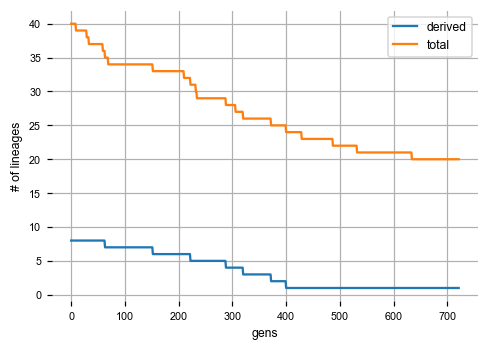

In [50]:
import os
os.chdir('/Users/vivaswatshastry/selCoefEst/PReFerSims')

haps = read_mssel('msselfiles/haps-500.0_14_x30.ms',40)
plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend()

In [26]:
# foo = lambda s: calc_genlik_constant(s, 500, 10000, haps)
# logprob = foo(-2.5)
foo(-4)

# plt.plot(np.exp(logprob),'k+',alpha=0.7); plt.ylabel('probability'); plt.xlabel('gens'); plt.grid(); plt.box(False); #plt.semilogy(); 
# plt.plot(np.exp(logprob),'b*',alpha=0.5)
# plt.plot(np.exp(logprob02),np.exp(logprob),'ko'); plt.axline((0,0),slope=1,color='grey'); plt.loglog(); plt.box(False); plt.xlabel('neutral coal. prob'); plt.ylabel('gen. prob.');
# plt.plot(np.exp(logprob02[np.where(logprob02>-1)]), np.exp(logprob[np.where(logprob>-1)]), 'ko'); plt.axline((1,1),slope=1,color='grey'); plt.xlabel('neutral coal. prob'); plt.ylabel('gen. prob.'); plt.box(False)

0.0001


204.41370017102744

In [22]:
# fsprojnm1[haps[t-1,0]-1]/fsprojn[haps[t-1,0]], fsprojnm1[haps[t-1,0]+1]/fsprojn[haps[t-1,0]]
# np.log(rCa*0.5/10000), np.log(rCA*0.5/10000)

1220

In [79]:
res500 = []
for rep in range(1,26):
    try:
        haps = read_mssel('msselfiles/haps-500.0_{}_x30.ms'.format(rep),40)
        foo = lambda s: calc_genlik_constant(s, 500, 10000, haps)
        # res500.append(10**sp.optimize.minimize_scalar(foo, method='bounded', bounds=(-4,-1.3), options={'xatol':1e-3}).x)
        res500.append(sp.optimize.minimize_scalar(foo, method='bounded', bounds=(-4,-1.3), options={'xatol':1e-3}).x)
        # finalll = Parallel(n_jobs=8)(delayed(foo)(x) for x in np.linspace(-4,-1.5,16))
        # res25[rep-1] = 10**np.linspace(-4,-1.5,16)[np.nanargmin(finalll)]
        # print(res100[rep-1])
    except:
        res500.append(np.nan)

0.0010747519218222697
0.004663282972106679
0.011550916934606623
0.020233700109201815
0.025598980204449832
0.020716063821922672
0.021264417306468837
0.021475415238287426
0.02145521915401539
0.02143875676112488
0.0010747519218222697
0.004663282972106679
0.011550916934606623
0.020233700109201815
0.036341852021369414
0.01986310031830066
0.022576273339585517
0.027078559739667638
0.021527264239440187
0.021510746568085933
0.021543841520605744
0.021932501833424423
0.021560384604664872
0.0010747519218222697
0.004663282972106679
0.011550916934606623
0.020233700109201815
0.012984407271266995
0.014192998322882702
0.014318163776206108
0.014245280204827845
0.014256218957422595
0.014234349845504037
0.0010747519218222697
0.004663282972106679
0.011550916934606623
0.020233700109201815
0.012588106188963357
0.014203285618072001
0.014808884468772225
0.01450620006965239
0.014495069511227766
0.014517339175075063
0.0010747519218222697
0.004663282972106679
0.011550916934606623
0.020233700109201815
0.0235967638

In [1]:
# plt.boxplot(np.array(res500)); plt.ylabel(r'$\hat s$'); plt.grid(); plt.box(False); plt.axhline(500/20000,color='grey');

NameError: name 'plt' is not defined

In [ ]:
# fsa = run_mom_iterate_constant(len(haps)+1, 500, 1e-3, 10000, 400)
# plt.imshow(np.log10(fsa),vmin=-10,aspect='auto',cmap='OrRd'); plt.colorbar()
# plt.plot(moments.Spectrum(fsa[10,]).project([40]),'o'); plt.plot(moments.Spectrum(fsa[100,]).project([40]),'o'); plt.plot(moments.Spectrum(fsa[400,]).project([40]),'o'); plt.semilogy(); 
moments.Spectrum(fsa[10,]).project([10])[1]
# plt.plot(np.log10(fsa.sum(axis=0)),'-o')
# np.where(np.array(res100)>0.01)[0], np.where(np.isnan(res100))

In [ ]:
# fsa = run_mom_iterate_constant(T, 3, s, N, 100, {})
# fs = moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(400,gamma=-25))*400
# fs = fs/fs.sum()
# plt.plot(fs.project([2]))
# fs.project([3])/fs.project([3]).sum() #[-- 0.9726728471678365 0.026575356182170495 0.0007517966499929211 --]
# fsap = (fsa.T/fsa.sum(axis=1)).T

### Computing the MLE $\hat s$ values for each simulated trajectory in PReFerSim -> bioinfo -> mssel -> ipynb

In [ ]:
# dft = pd.read_csv('outfiles/ConstantSize-50.0.1.full_out.txt',sep='\t',header=None,names=['','Xl','s','al','id'])
# dft['sXl'] = (dft['Xl']*200).astype('int')
# dft['al'] = 80000+1 - dft['al']
# dft['al'] = dft['al'].astype('int')
# dft = dft.drop(np.where(dft['sXl']==200)[0])
# dft['res'] = np.zeros(dft.shape[0])
# plt.boxplot(dft['res']); plt.semilogy(); plt.axhline(0.025,color='red'); plt.xlabel(r'$\hat s$'); 
# plt.plot(dft['al'],dft['res'],'ko'); plt.semilogy(); plt.grid(); plt.box(False); plt.xlabel('allele age'); plt.ylabel(r'$\hat s$')
# plt.plot(dft['sXl']*0.2,dft['res'],'ko'); plt.semilogy(); plt.grid(); plt.box(False); plt.xlabel('sample freq.'); plt.ylabel(r'$\hat s$')
# plt.plot(dft['sXl']/dft['al'],dft['res'],'ko'); plt.semilogy(); plt.grid(); plt.box(False); plt.ylabel(r'$\hat s$'); plt.axhline(0.025,color='red'); plt.xlabel(r'$i/a$')
# plt.boxplot(dft['res'].loc[((dft['res']>2e-6) & (dft['res']<0.8e-1))]); plt.axhline(0.025, color='red'); plt.xlabel(r'$\hat s$'); plt.semilogy(); plt.ylim((1e-3,1e-1))
# plt.scatter(dft['al'].loc[((dft['res']>2e-6) & (dft['res']<0.8e-1))],dft['sXl'].loc[((dft['res']>2e-6) & (dft['res']<0.8e-1))]*0.2); plt.xlabel('allele age'); plt.ylabel('sample freq.'); plt.grid()

In [ ]:
# os.system("sed -n '/^{}/p' MiniTest/Traj-500.0.txt > MiniTest/TrajMini-500.0.txt".format(dft['al'].iloc[i]))
# np.where(((dft['sXl']>3) & (dft['sXl']<150)))[0]
# i = 40
# os.system("sed -n '/^{}/p' MiniTest/Traj-50.0.txt > MiniTest/TrajMini-50.0.txt".format(dft['id'].iloc[i]))
# os.system("perl TrajToMsselFormat.pl MiniTest/TrajMini-50.0 20000 msselfiles/trajfiles/TrajMsselLike-50.0.txt 1 0 1")
# os.system("cat msselfiles/trajfiles/TrajMsselLike-50.0.txt | ~/mssel/stepftn > msselfiles/trajfiles/CurrTraj-50.0.txt")
# os.system("~/mssel/mssel3 50 1 {} {} msselfiles/trajfiles/CurrTraj-50.0.txt 500 -r 0 1000 -t 20 -T > msselfiles/haps-50.0.ms".format(int(np.floor((200-dft['sXl'].iloc[i]) * 0.25)),int(np.ceil(dft['sXl'].iloc[i] * 0.25))))
# print(dft['sXl'].iloc[i], dft['al'].iloc[i])

# res = [0.00016259837958348586]
res25 = []

for rep in range(1,26):
    try:
        haps = read_mssel('msselfiles/haps-25.0_{}.ms'.format(rep),40)
        foo = lambda s: calc_genlik(s, 500, 10000, haps)
        res25.append(10**sp.optimize.minimize_scalar(foo, method='bounded', bounds=(-5,-2), options={'xatol':1e-3}).x)
        print(res25[rep-1])
    except:
        res25.append(np.nan)
# plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend(); plt.title(r'$\gamma=100$')

In [ ]:
# int(np.floor((200-dft['sXl'].iloc[i]) * 0.5)),int(np.ceil(dft['sXl'].iloc[i] * 0.5))
# plt.hist(res[1:])
# plt.boxplot(np.array(res)[~np.isnan(res).astype(int)]); plt.axhline(0.01,color='red'); plt.ylim((0.0001,0.1)); plt.semilogy()

In [ ]:
## bioinformatics to run mssel
# for i in range(56,len(dft)):
#     os.system("sed -n '/^{}/p' MiniTest/Traj-50.0.txt > MiniTest/TrajMini-50.0.txt".format(dft['id'].iloc[i]))
#     os.system("perl TrajToMsselFormat.pl MiniTest/TrajMini-50.0 20000 msselfiles/trajfiles/TrajMsselLike-50.0.txt 1 0 1")
#     os.system("cat msselfiles/trajfiles/TrajMsselLike-50.0.txt | ~/mssel/stepftn > msselfiles/trajfiles/CurrTraj-50.0.txt")
#     os.system("~/mssel/mssel3 40 1 {} {} msselfiles/trajfiles/CurrTraj-50.0.txt 500 -r 0 1000 -t 20 -T > msselfiles/haps-50.0.ms".format(int(np.floor((200-dft['sXl'].iloc[i]) * 0.2)),int(np.ceil(dft['sXl'].iloc[i] * 0.2))))

#     try: 
#         haps = read_mssel('msselfiles/haps-50.0.ms',40)
#     except:
#         dft['res'].iloc[i] = np.nan
#         continue
#     # plt.plot(haps[:,0],label='derived'); plt.plot(haps[:,1], label='total'); plt.ylabel('# of lineages'); plt.xlabel('gens'); plt.grid(); plt.box(False); plt.legend(); plt.title(r'$\gamma=50$')

#     foo = lambda s: calc_genlik(s, 500, 10000, haps)
#     dft['res'].iloc[i] = 10**sp.optimize.minimize_scalar(foo, method='bounded', bounds=(-5,-2), options={'xatol':1e-3}).x
#     print(i, dft['sXl'].iloc[i], dft['al'].iloc[i], dft['res'].iloc[i])
#     # print(10**res.x)

In [ ]:
res